In [1]:
import numpy as np

class HarmonySearchConstrained:
    def __init__(
        self,
        objective_func,
        bounds,
        constraint_func=None,
        hms=30,              # Harmony Memory Size
        hmcr=0.7,            # Harmony Memory Considering Rate
        par=0.7,             # Pitch Adjusting Rate
        seg=300,             # bw for Pitch Adjustment
        max_iter=30000,      # Number of improvisations (iterations)
        max_resample=10000,   # Max trials to resample until a feasible solution is found
        seed=5
    ):
        """
        Parameters
        ----------
        objective_func : callable
            Function f(x) to minimize. x is a 1D numpy array.
        bounds : list of tuple
            [(x1_min, x1_max, "any" or "int"), (x2_min, x2_max, "any" or "int"), ...]
            If the 3rd element is omitted, "any" is assumed.
        constraint_func : callable or None
            Function g(x) -> bool.
            Return True if x is feasible, False otherwise.
            If None, all solutions are treated as feasible (unconstrained).
        hms : int
            Harmony Memory Size.
        hmcr : float
            Harmony Memory Considering Rate (0 ~ 1).
        par : float
            Pitch Adjusting Rate (0 ~ 1).
        seg : int
            Division number for calculating pitch adjustment step size
        max_iter : int
            Number of improvisations.
        max_resample : int
            Maximum number of trials to resample until a feasible solution is found.
        seed : int or None
            Random seed for reproducibility.
        """
        self.objective_func = objective_func
        self.constraint_func = constraint_func

        # Extract numeric bounds and variable types
        self.dim = len(bounds)
        self.bounds = np.array([(b[0], b[1]) for b in bounds], dtype=float)
        self.types = [
            (b[2].lower() if len(b) > 2 else "any") for b in bounds
        ]

        # Variable-wise bandwidth: (max - min) / 300
        span = self.bounds[:, 1] - self.bounds[:, 0]
        # If span is zero, bw_j becomes 0 (no movement), which is fine.
        self.bw_vec = span / seg

        self.hms = hms
        self.hmcr = hmcr
        self.par = par
        self.max_iter = max_iter
        self.max_resample = max_resample

        self.rng = np.random.default_rng(seed)

        # Harmony Memory (HM)
        self.HM = None          # shape: (hms, dim)
        self.HM_f = None        # shape: (hms,)
        self.best_x = None
        self.best_f = None

        # History of best objective values
        self.history_best_f = []

    # ======================================================
    # Feasibility helpers
    # ======================================================
    def _is_feasible(self, x):
        """Check if x satisfies the constraints."""
        if self.constraint_func is None:
            return True
        return bool(self.constraint_func(x))

    def _sample_random_variable(self, j):
        """Sample a single variable j within its bounds, with type handling."""
        lower, upper = self.bounds[j]
        value = self.rng.uniform(lower, upper)
        if self.types[j] == "int":
            value = round(value)
        value = np.clip(value, lower, upper)
        return value

    def _sample_feasible_random(self):
        """
        Sample a feasible solution uniformly at random within bounds.
        Resample until feasible or max_resample is reached.
        """
        for _ in range(self.max_resample):
            x = np.empty(self.dim)
            for j in range(self.dim):
                x[j] = self._sample_random_variable(j)

            if self._is_feasible(x):
                return x

        raise RuntimeError(
            "Failed to sample a feasible solution within max_resample from bounds."
        )

    # ======================================================
    # HS core
    # ======================================================
    def _initialize_harmony_memory(self):
        """Initialize Harmony Memory with feasible random solutions."""
        self.HM = np.empty((self.hms, self.dim))

        for i in range(self.hms):
            self.HM[i] = self._sample_feasible_random()

        # Evaluate all harmonies
        self.HM_f = np.apply_along_axis(self.objective_func, 1, self.HM)

        # Find the best harmony
        best_idx = np.argmin(self.HM_f)
        self.best_x = self.HM[best_idx].copy()
        self.best_f = self.HM_f[best_idx]

    def _improvise_new_feasible_harmony(self):
        """
        Improvise a new feasible harmony (solution) according to HS rules.
        If the generated harmony is infeasible, discard and try again.
        """
        for _ in range(self.max_resample):
            new_x = np.empty(self.dim)

            for j in range(self.dim):
                lower, upper = self.bounds[j]

                if self.rng.random() < self.hmcr:
                    # Memory consideration: choose from existing HM
                    idx = self.rng.integers(0, self.hms)
                    value = self.HM[idx, j]

                    # Pitch adjustment
                    if self.rng.random() < self.par:
                        bw_j = self.bw_vec[j]
                        # If bw_j is zero, step will be zero
                        step = self.rng.uniform(-bw_j, bw_j)
                        if self.types[j] == "int":
                            step = 1
                        value = value + step
                else:
                    # Random selection within bounds
                    value = self.rng.uniform(lower, upper)

                # Type handling: integer or real
                if self.types[j] == "int":
                    value = round(value)

                # Apply bounds (simple clipping)
                value = np.clip(value, lower, upper)
                new_x[j] = value

            # Check feasibility
            if self._is_feasible(new_x):
                return new_x

        # As a last resort, try a purely random feasible sample
        return self._sample_feasible_random()

    def _update_harmony_memory(self, new_x, new_f):
        """
        If new harmony is better than the worst in HM, replace it.
        """
        worst_idx = np.argmax(self.HM_f)
        if new_f < self.HM_f[worst_idx]:
            self.HM[worst_idx] = new_x
            self.HM_f[worst_idx] = new_f

        # Update global best
        if new_f < self.best_f:
            self.best_x = new_x.copy()
            self.best_f = new_f

    def run(self, verbose=False):
        """
        Run Harmony Search optimization.

        Returns
        -------
        best_x : numpy.ndarray
            Best solution found (feasible).
        best_f : float
            Objective function value at best_x.
        history_best_f : list of float
            Best objective values along iterations.
        """
        # Initialize HM with feasible solutions
        self._initialize_harmony_memory()
        self.history_best_f = [self.best_f]

        # Main improvisation loop
        for it in range(1, self.max_iter + 1):
            # Improvise new feasible harmony
            new_x = self._improvise_new_feasible_harmony()
            new_f = self.objective_func(new_x)

            # Update HM
            self._update_harmony_memory(new_x, new_f)
            self.history_best_f.append(self.best_f)

            if verbose and (it % (self.max_iter // 10 if self.max_iter >= 10 else 1) == 0):
                print(f"Iter {it:7d} | Best f = {self.best_f:.6e}")

        return self.best_x, self.best_f, self.history_best_f


In [2]:
# ==========================================================
# Example 1: Tension/compression spring design problem
# ==========================================================

def spring_obj(x):
    """
    Tension/compression spring design objective function.
    x: [x1, x2, x3]
    f(x) = (x3 + 2) * x2 * x1^2
    """
    x = np.asarray(x, dtype=float)
    x1, x2, x3 = x
    return (x3 + 2.0) * x2 * x1**2


def spring_cons(x):
    """
    Spring design constraints g1..g4(x) <= 0.
    Returns True if all constraints are satisfied.
    """
    x = np.asarray(x, dtype=float)
    x1, x2, x3 = x

    # g1(x) = 1 - (x2^3 * x3) / (71,785 x1^4) <= 0
    g1 = 1.0 - (x2**3 * x3) / (71_785.0 * x1**4)

    # g2(x) = (4x2^2 - x1 x2) / (12,566 (x2 x1^3 - x1^4)) + 1/(5,108 x1^2) - 1 <= 0
    denom = 12_566.0 * (x2 * x1**3 - x1**4)
    if abs(denom) < 1e-12:
        return False
    g2 = (4.0 * x2**2 - x1 * x2) / denom + 1.0 / (5_108.0 * x1**2) - 1.0

    # g3(x) = 1 - 140.45 x1 / (x2^2 x3) <= 0
    g3 = 1.0 - (140.45 * x1) / (x2**2 * x3)

    # g4(x) = (x1 + x2) / 1.5 - 1 <= 0
    g4 = (x1 + x2) / 1.5 - 1.0

    return (g1 <= 0.0) and (g2 <= 0.0) and (g3 <= 0.0) and (g4 <= 0.0)


bounds_spring = [
    (0.05, 2.0, "any"),   # x1
    (0.25, 1.3, "any"),   # x2
    (2.0, 15.0, "any")    # x3
]


# ==========================================================
# Example 2: Pressure vessel design problem
# ==========================================================

def pressure_vessel_obj(x):
    """
    Pressure vessel design objective function.
    x: [x1, x2, x3, x4]
    f(x) = 0.6224 x1 x3 x4 + 1.7781 x2 x3^2 + 3.1661 x1^2 x4 + 19.84 x1^2 x3
    """
    x = np.asarray(x, dtype=float)
    x1, x2, x3, x4 = x

    return (
        0.6224 * (0.0625*x1) * x3 * x4 + 1.7781 * (0.0625*x2) * x3**2 + 3.1661 * (0.0625*x1)**2 * x4 + 19.84  * (0.0625*x1)**2 * x3
    )


def pressure_vessel_cons(x):
    """
    Pressure vessel design constraints g1..g4(x) <= 0.
    Returns True if all constraints are satisfied.
    """
    x = np.asarray(x, dtype=float)
    x1, x2, x3, x4 = x

    # g1(x) = -x1 + 0.0193 x3 <= 0
    g1 = -0.0625*x1 + 0.0193 * x3

    # g2(x) = -x2 + 0.00954 x3 <= 0
    g2 = -0.0625*x2 + 0.00954 * x3

    # g3(x) = -pi x3^2 x4 - (4/3) pi x3^3 + 1,296,000 <= 0
    g3 = -np.pi * x3**2 * x4 - (4.0 / 3.0) * np.pi * x3**3 + 1_296_000.0

    # g4(x) = x4 - 240 <= 0
    g4 = x4 - 240.0

    return (g1 <= 0.0) and (g2 <= 0.0) and (g3 <= 0.0) and (g4 <= 0.0)


bounds_pressure_vessel = [
    (1.0, 99.0, "int"),  # x1 (thickness, integer multiple of 0.0625 if scaled)
    (1.0, 99.0, "int"),  # x2
    (10.0,   200.0,        "any"),   # x3
    (10.0,   200.0,        "any"),   # x4
]

# ==========================================================
# Example 3: 3bar truss design
# ==========================================================
def truss_obj(x):
    """
    Objective function:
        f(x) = (2 * sqrt(2) * x1 + x2) * L
    x : [x1, x2]
    """
    x = np.asarray(x, dtype=float)
    x1, x2 = x

    return (2.0 * np.sqrt(2.0) * x1 + x2) * 100

def truss_cons(x):
    """
    Constraint set:
        g1(x) = ((sqrt(2)*x1 + x2) / sqrt(2*x1^2 + 2*x1*x2)) * P - SIGMA <= 0
        g2(x) = (x2 / sqrt(2*x1^2 + 2*x1*x2)) * P - SIGMA <= 0
        g3(x) = (1 / sqrt(2*x2 + x1)) * P - SIGMA <= 0

    Returns True if all constraints are satisfied.
    """
    x = np.asarray(x, dtype=float)
    x1, x2 = x

    # Common denominator term for g1, g2
    denom = np.sqrt(2.0) * x1**2 + 2.0 * x1 * x2
    if denom < 1e-12:
        # Avoid division by zero -> treat as infeasible
        return False

    g1 = ((np.sqrt(2.0) * x1 + x2) / denom) * 2 - 2
    g2 = (x2 / denom) * 2 - 2

    # Denominator for g3
    denom3 = np.sqrt(2.0) * x2 + x1
    if denom3 < 1e-12:
        return False

    g3 = (1.0 / denom3) * 2 - 2

    return (g1 <= 0.0) and (g2 <= 0.0) and (g3 <= 0.0)

bounds_truss = [
    (0.0, 1.0, "any"),  # x1
    (0.0, 1.0, "any")   # x2
]

# ==========================================================
# Example 4: speed reducer optimization
# ==========================================================

def speed_obj(x):
    x = np.asarray(x, dtype=float)
    x1, x2, x3, x4, x5, x6, x7 = x

    return (
        0.7854 * x1 * x2**2 * (3.3333 * x3**2 + 14.9334 * x3 - 43.0934)
        - 1.508 * x1 * (x6**2 + x7**2)
        + 7.4777 * (x6**3 + x7**3)
        + 0.7854 * (x4 * x6**2 + x5 * x7**2)
    )

def speed_cons(x):
    """
    Return True if all constraints g1..g11(x) <= 0.
    """
    x = np.asarray(x, dtype=float)
    x1, x2, x3, x4, x5, x6, x7 = x

    # g1 ~ g4
    g1 = 27.0 / (x1 * x2**2 * x3) - 1.0
    g2 = 397.5 / (x1 * x2**2 * x3**2) - 1.0
    g3 = (1.93 * x4**3) / (x2 * x3 * x6**4) - 1.0
    g4 = (1.93 * x5**3) / (x2 * x3 * x7**4) - 1.0

    # g5, g6
    g5 = (1.0 / (110.0 * x6**3)) * np.sqrt(((745.0 * x4) / (x2 * x3))**2 + 16.9e6) - 1.0
    g6 = (1.0 / (85.0 * x7**3)) * np.sqrt(((745.0 * x5) / (x2 * x3))**2 + 157.5e6) - 1.0

    # g7 ~ g11
    g7  = (x2 * x3) / 40.0 - 1.0
    g8  = (5.0 * x2) / x1 - 1.0
    g9  = (x1 / (12.0 * x2)) - 1.0
    g10 = (1.5 * x6 + 1.9) / x4 - 1.0
    g11 = (1.1 * x7 + 1.9) / x5 - 1.0

    return (
        g1 <= 0 and g2 <= 0 and g3 <= 0 and g4 <= 0 and
        g5 <= 0 and g6 <= 0 and g7 <= 0 and g8 <= 0 and g9 <= 0 and g10 <= 0 and g11 <= 0
    )

bounds_speed = [
    (2.6, 3.6, "any"),   # x1
    (0.7, 0.8, "any"),   # x2
    (17, 28, "int"), # x3
    (7.3, 8.3, "any"),   # x4
    (7.8, 8.3, "any"),   # x5
    (2.9, 3.9, "any"),   # x6
    (5.0, 5.5, "any"),   # x7
]

In [3]:
hs = HarmonySearchConstrained(
    objective_func=truss_obj,
    bounds=bounds_truss,
    constraint_func=truss_cons
)

best_x, best_f, history = hs.run(verbose=True)
print("Best feasible solution:", best_x)
print("Best objective value:", best_f)

Iter    3000 | Best f = 2.638981e+02
Iter    6000 | Best f = 2.638960e+02
Iter    9000 | Best f = 2.638960e+02
Iter   12000 | Best f = 2.638960e+02
Iter   15000 | Best f = 2.638960e+02
Iter   18000 | Best f = 2.638960e+02
Iter   21000 | Best f = 2.638960e+02
Iter   24000 | Best f = 2.638960e+02
Iter   27000 | Best f = 2.638960e+02
Iter   30000 | Best f = 2.638960e+02
Best feasible solution: [0.7890053  0.40731564]
Best objective value: 263.8959642894395


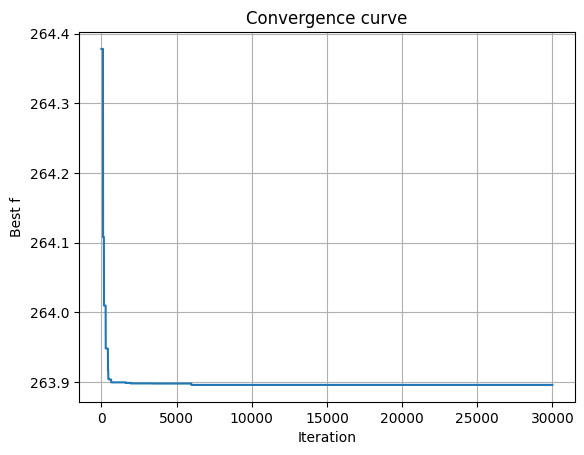

In [4]:
import matplotlib.pyplot as plt

# Plot convergence: best_f vs iteration
plt.figure()
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best f")
plt.title("Convergence curve")
plt.grid(True)
plt.show()

In [5]:
xxx = [3.5,0.7,17,7.3,7.8,3.351,5.287]
ccc = speed_obj(xxx)
print(ccc)
print(speed_cons(xxx))

2996.749807722576
True
